In [1]:
# Complete Implementation of Algorithms 4 and 11 from Halko, Martinsson, and Tropp (2010)
# "Finding Structure with Randomness: Probabilistic Algorithms for Matrix Decompositions"

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

PyTorch version: 2.5.1
Device: cuda


In [3]:
# ============================================================================
# ALGORITHM 4: RANDOMIZED SUBSPACE ITERATION (Full Implementation)
# ============================================================================

def algorithm_4_randomized_subspace_iteration(A, ell, q):
    """
    Algorithm 4: Randomized Subspace Iteration

    Input: Matrix A, integers ell (sample size), q (power iterations)
    Output: Orthonormal matrix Q approximating range of A

    This is the EXACT implementation from the paper.
    """
    m, n = A.shape

    # Step 1: Draw n × ℓ Gaussian matrix Ω
    Omega = np.random.randn(n, ell)

    # Step 2: Form Y₀ = AΩ, compute QR: Y₀ = Q₀R₀
    Y_0 = A @ Omega
    Q_j, R_0 = np.linalg.qr(Y_0)

    # Step 3: Power iteration loop
    for j in range(1, q + 1):
        # Step 3a: Form Ỹⱼ = A*Qⱼ₋₁, compute QR: Ỹⱼ = Q̃ⱼR̃ⱼ
        Y_tilde_j = A.T @ Q_j
        Q_tilde_j, R_tilde_j = np.linalg.qr(Y_tilde_j)

        # Step 3b: Form Yⱼ = AQ̃ⱼ, compute QR: Yⱼ = QⱼRⱼ
        Y_j = A @ Q_tilde_j
        Q_j, R_j = np.linalg.qr(Y_j)

    # Step 4: Output Q = Qᵩ
    return Q_j

In [4]:
# ============================================================================
# ALGORITHM 11: RANDOMIZED SVD WITH POWER ITERATION (Full Implementation)
# ============================================================================

def algorithm_11_randomized_svd_power_iteration(A, k, q=2):
    """
    Algorithm 11: Randomized SVD with Power Iteration

    Input: Matrix A, target rank k, power iterations q
    Output: U, Σ, V^T such that A ≈ UΣV^T

    This is the EXACT implementation from the paper.
    """
    m, n = A.shape

    # Step 1: Generate n × 2k Gaussian matrix Ω
    Omega = np.random.randn(n, 2 * k)

    # Step 2: Form Y = (AA*)^q AΩ using Algorithm 4
    # We use Algorithm 4 with ell = 2k and q power iterations
    Q = algorithm_4_randomized_subspace_iteration(A, 2 * k, q)

    # Step 3: Form B = Q*A
    B = Q.T @ A

    # Step 4: Compute SVD: B = ŨΣV*
    U_tilde, Sigma, Vt = np.linalg.svd(B, full_matrices=False)

    # Step 5: Set U = QŨ
    U = Q @ U_tilde

    # Step 6: Truncate to rank k
    rank = min(k, len(Sigma))
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]

    return U, Sigma, Vt

In [5]:
# ============================================================================
# ADDITIONAL ALGORITHMS FOR COMPARISON
# ============================================================================

def algorithm_2_basic_randomized_range_finder(A, ell):
    """
    Algorithm 2: Basic Randomized Range Finder

    Input: Matrix A, integer ell
    Output: Orthonormal matrix Q approximating range of A
    """
    m, n = A.shape

    # Step 1: Draw n × ℓ Gaussian random matrix Ω
    Omega = np.random.randn(n, ell)

    # Step 2: Form Y = AΩ
    Y = A @ Omega

    # Step 3: Compute QR factorization Y = QR to get orthonormal Q
    Q, R = np.linalg.qr(Y)

    return Q

def basic_randomized_svd(A, rank, oversampling=10):
    """
    Basic randomized SVD using Algorithm 2 + direct SVD
    """
    ell = min(rank + oversampling, min(A.shape))
    Q = algorithm_2_basic_randomized_range_finder(A, ell)
    B = Q.T @ A
    U_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    rank = min(rank, len(S))
    return U[:, :rank], S[:rank], Vt[:rank, :]


In [6]:
# ============================================================================
# SIMPLE CNN ARCHITECTURE (with FC Layers)
# ============================================================================

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)


In [7]:
# ============================================================================
# DATA LOADING
# ============================================================================

def load_cifar10_data(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    return DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2), \
           DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
# ============================================================================
# TRAINING AND EVALUATION
# ============================================================================

def train_model(model, trainloader, testloader, epochs=10, lr=0.001, verbose=True):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0.0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            loss_sum += loss.item()
        if verbose:
            print(f"Epoch {epoch}: Loss={loss_sum / len(trainloader):.4f}, Accuracy={100.*correct/total:.2f}%")
    return model

def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

In [9]:
def count_model_parameters(model):
    """Count total trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layer_parameters(layer):
    """Count parameters in a specific layer"""
    return sum(p.numel() for p in layer.parameters() if p.requires_grad)

In [10]:
# ============================================================================
# FC LAYER COMPRESSION
# ============================================================================

class CompressedFC(nn.Module):
    def __init__(self, U, S, Vt, bias=None):
        super(CompressedFC, self).__init__()
        self.U = nn.Parameter(torch.from_numpy(U).float().to(device))
        self.S = nn.Parameter(torch.from_numpy(S).float().to(device))
        self.Vt = nn.Parameter(torch.from_numpy(Vt).float().to(device))
        self.bias = nn.Parameter(bias.to(device)) if bias is not None else None

    def forward(self, x):
        x = x @ self.Vt.T
        x = x * self.S
        x = x @ self.U.T
        return x + self.bias if self.bias is not None else x

def compress_fc_layer(model, layer_name, rank, method='algorithm_11', q=2):
    """
    Compress FC layer using different randomized SVD methods

    Methods:
    - 'algorithm_11': Algorithm 11 from paper (recommended)
    - 'algorithm_4': Algorithm 4 + direct SVD
    - 'basic': Basic randomized SVD (Algorithm 2)
    """
    layer = getattr(model, layer_name)
    W = layer.weight.data.cpu().numpy()
    bias = layer.bias.data if layer.bias is not None else None
    rank = min(rank, min(W.shape) - 1)
    
    # Count original parameters
    original_params = count_layer_parameters(layer)

    start_time = time.time()

    if method == 'algorithm_11':
        U, S, Vt = algorithm_11_randomized_svd_power_iteration(W, rank, q)
    elif method == 'algorithm_4':
        # Use Algorithm 4 for range finding, then direct SVD
        Q = algorithm_4_randomized_subspace_iteration(W, rank + 10, q)
        B = Q.T @ W
        U_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)
        U = Q @ U_tilde
        rank = min(rank, len(S))
        U, S, Vt = U[:, :rank], S[:rank], Vt[:rank, :]
    elif method == 'basic':
        U, S, Vt = basic_randomized_svd(W, rank)
    else:
        raise ValueError(f"Unknown method: {method}")

    elapsed = time.time() - start_time

    # Replace the layer
    setattr(model, layer_name, CompressedFC(U, S, Vt, bias))
    
    # Count compressed parameters
    compressed_params = count_layer_parameters(getattr(model, layer_name))

    # Calculate compression statistics
    layer_compression_ratio = original_params / compressed_params

    print(f"{layer_name} compressed with {method} (rank {rank}), "
          f"ratio {layer_compression_ratio:.2f}x, time {elapsed:.3f}s, "
          f"params: {original_params} -> {compressed_params}")

    return layer_compression_ratio, elapsed, original_params, compressed_params

In [11]:
# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_algorithm_comparison_with_retraining(results, original_accuracy, retrain_epochs):
    """Plot comparison of different algorithms with retraining results - separate plots"""
    
    # Plot 1: Baseline Accuracy vs Rank (No Retraining)
    plt.figure(figsize=(10, 6))
    for method in results:
        plt.plot(results[method]['ranks'], results[method]['accuracies'],
                 marker='o', linewidth=2, markersize=8, label=method.replace('_', ' ').title())
    plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original Model')
    plt.xlabel("Rank", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.title("Baseline Accuracy vs Rank (No Retraining)", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 2: Retraining Improvement by Method
    plt.figure(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    markers = ['o', 's', '^']
    
    for method_idx, method in enumerate(results):
        for rank_idx, rank in enumerate(results[method]['ranks']):
            baseline_acc = results[method]['accuracies'][rank_idx]
            retrain_accs = results[method]['retrained_accuracies'][rank_idx]
            improvements = [acc - baseline_acc for acc in retrain_accs]
            
            plt.plot(retrain_epochs, improvements, 
                    color=colors[method_idx], marker=markers[method_idx],
                    linewidth=2, markersize=6, alpha=0.7,
                    label=f"{method.replace('_', ' ').title()} - Rank {rank}")
    
    plt.xlabel("Retraining Epochs", fontsize=12)
    plt.ylabel("Accuracy Improvement (%)", fontsize=12)
    plt.title("Accuracy Improvement with Retraining by Method and Rank", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot 3: Best Retraining Results vs Baseline
    plt.figure(figsize=(10, 6))
    for method in results:
        best_retrain_accs = []
        for rank_idx in range(len(results[method]['ranks'])):
            retrain_accs = results[method]['retrained_accuracies'][rank_idx]
            best_retrain_accs.append(max(retrain_accs))
        
        # Plot best retraining results
        plt.plot(results[method]['ranks'], best_retrain_accs,
                 marker='s', linewidth=2, markersize=8,
                 label=f"{method.replace('_', ' ').title()} (Best Retrain)")
        
        # Plot baseline results with dashed line
        plt.plot(results[method]['ranks'], results[method]['accuracies'],
                 marker='o', linestyle='--', linewidth=2, markersize=6, alpha=0.6,
                 label=f"{method.replace('_', ' ').title()} (Baseline)")
    
    plt.axhline(y=original_accuracy, color='red', linestyle=':', linewidth=2, label='Original Model')
    plt.xlabel("Rank", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.title("Best Retraining Results vs Baseline Accuracy", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot 4: Individual Method Retraining Curves
    for method in results:
        plt.figure(figsize=(10, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(results[method]['ranks'])))
        
        for rank_idx, rank in enumerate(results[method]['ranks']):
            retrain_accs = results[method]['retrained_accuracies'][rank_idx]
            plt.plot(retrain_epochs, retrain_accs, 
                    marker='o', linewidth=2, markersize=8, 
                    color=colors[rank_idx], label=f'Rank {rank}')
        
        plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original Model')
        plt.xlabel("Retraining Epochs", fontsize=12)
        plt.ylabel("Test Accuracy (%)", fontsize=12)
        plt.title(f"{method.replace('_', ' ').title()}: Retraining Performance Curves", 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    # Plot 5: Compression Ratio vs Best Accuracy After Retraining
    plt.figure(figsize=(10, 6))
    for method in results:
        best_retrain_accs = []
        for rank_idx in range(len(results[method]['ranks'])):
            retrain_accs = results[method]['retrained_accuracies'][rank_idx]
            best_retrain_accs.append(max(retrain_accs))
        
        plt.scatter(results[method]['compression_ratios'], best_retrain_accs,
                   s=100, alpha=0.7, label=method.replace('_', ' ').title())
        
        # Add rank annotations
        for i, rank in enumerate(results[method]['ranks']):
            plt.annotate(f'R{rank}', 
                        (results[method]['compression_ratios'][i], best_retrain_accs[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original Model')
    plt.xlabel("Compression Ratio", fontsize=12)
    plt.ylabel("Best Test Accuracy After Retraining (%)", fontsize=12)
    plt.title("Compression Ratio vs Best Accuracy After Retraining", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 6: Retraining Epochs vs Final Accuracy (Heatmap style for each method)
    for method in results:
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create matrix for heatmap
        retrain_matrix = np.array(results[method]['retrained_accuracies'])
        
        # Create heatmap
        im = ax.imshow(retrain_matrix, cmap='RdYlGn', aspect='auto', 
                      vmin=retrain_matrix.min(), vmax=max(retrain_matrix.max(), original_accuracy))
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Accuracy (%)', fontsize=12)
        
        # Set ticks and labels
        ax.set_xticks(range(len(retrain_epochs)))
        ax.set_xticklabels(retrain_epochs)
        ax.set_yticks(range(len(results[method]['ranks'])))
        ax.set_yticklabels([f"Rank {r}" for r in results[method]['ranks']])
        
        # Add text annotations
        for i in range(len(results[method]['ranks'])):
            for j in range(len(retrain_epochs)):
                text = ax.text(j, i, f'{retrain_matrix[i, j]:.1f}%',
                              ha="center", va="center", color="black", fontweight='bold')
        
        ax.set_xlabel("Retraining Epochs", fontsize=12)
        ax.set_ylabel("Compression Rank", fontsize=12)
        ax.set_title(f"{method.replace('_', ' ').title()}: Accuracy Heatmap", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Plot 7: Recovery Rate (How much of original accuracy is recovered)
    plt.figure(figsize=(12, 6))
    for method in results:
        recovery_rates = []
        for rank_idx in range(len(results[method]['ranks'])):
            baseline_acc = results[method]['accuracies'][rank_idx]
            retrain_accs = results[method]['retrained_accuracies'][rank_idx]
            best_retrain_acc = max(retrain_accs)
            
            # Calculate recovery rate: (best_retrain - baseline) / (original - baseline)
            if original_accuracy > baseline_acc:
                recovery_rate = (best_retrain_acc - baseline_acc) / (original_accuracy - baseline_acc) * 100
            else:
                recovery_rate = 100  # Already at or above original
            recovery_rates.append(recovery_rate)
        
        plt.plot(results[method]['ranks'], recovery_rates,
                marker='o', linewidth=2, markersize=8,
                label=method.replace('_', ' ').title())
    
    plt.axhline(y=100, color='red', linestyle='--', linewidth=2, label='Full Recovery')
    plt.xlabel("Rank", fontsize=12)
    plt.ylabel("Recovery Rate (%)", fontsize=12)
    plt.title("Accuracy Recovery Rate After Retraining", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot: Overall Model Compression vs Best Accuracy After Retraining
    plt.figure(figsize=(10, 6))
    for method in results:
        best_retrain_accs = []
        for rank_idx in range(len(results[method]['ranks'])):
            retrain_accs = results[method]['retrained_accuracies'][rank_idx]
            best_retrain_accs.append(max(retrain_accs))
        
        plt.scatter(results[method]['overall_compression_ratios'], best_retrain_accs,
                   s=100, alpha=0.7, label=method.replace('_', ' ').title())
        
        # Add rank annotations
        for i, rank in enumerate(results[method]['ranks']):
            plt.annotate(f'R{rank}', 
                        (results[method]['overall_compression_ratios'][i], best_retrain_accs[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2, label='Original Model')
    plt.xlabel("Overall Model Compression Ratio", fontsize=12)
    plt.ylabel("Best Test Accuracy After Retraining (%)", fontsize=12)
    plt.title("Overall Model Compression vs Best Accuracy After Retraining", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

In [12]:
# ============================================================================
# COMPREHENSIVE EXPERIMENT
# ============================================================================

def comprehensive_fc_compression_experiment():
    """
    Comprehensive experiment comparing all three algorithms with retraining
    """
    print("Loading data and training original model...")
    trainloader, testloader = load_cifar10_data()

    # Train original model
    model = SimpleCNN()
    print("Training original model...")
    train_model(model, trainloader, testloader, epochs=5)
    original_acc = evaluate_model(model, testloader)
    original_total_params = count_model_parameters(model)
    print(f"Original accuracy: {original_acc:.2f}%")
    print(f"Original total parameters: {original_total_params:,}")

    # Test different ranks and retraining epochs
    ranks = [8, 16, 32, 64, 128]
    retrain_epochs = [0, 1, 3, 5]
    methods = ['algorithm_11', 'algorithm_4', 'basic']
    results = {}

    for method in methods:
        print(f"\n=== Testing {method.replace('_', ' ').title()} ===")
        results[method] = {
            'ranks': [],
            'accuracies': [],
            'compression_ratios': [],
            'overall_compression_ratios': [],  # NEW: Overall model compression
            'times': [],
            'retrain_epochs': [],
            'retrained_accuracies': [],
            'original_params': [],  # NEW: Track parameter counts
            'compressed_params': []  # NEW: Track parameter counts
        }

        for rank in ranks:
            print(f"Testing rank {rank}...")
            
            retrained_accs_for_rank = []
            
            for retrain_epoch in retrain_epochs:
                # Create a copy of the original model
                model_copy = SimpleCNN()
                model_copy.load_state_dict(model.state_dict())
                original_model_params = count_model_parameters(model_copy)

                # Compress FC layers
                total_time = 0
                layer_compression_ratios = []
                total_original_params = 0
                total_compressed_params = 0

                # Compress fc1 and fc2 layers
                ratio1, time1, orig1, comp1 = compress_fc_layer(model_copy, 'fc1', rank, method)
                ratio2, time2, orig2, comp2 = compress_fc_layer(model_copy, 'fc2', rank//2, method)

                total_time = time1 + time2
                avg_layer_compression_ratio = (ratio1 + ratio2) / 2
                total_original_params = orig1 + orig2
                total_compressed_params = comp1 + comp2
                
                # Calculate overall model compression ratio
                compressed_model_params = count_model_parameters(model_copy)
                overall_compression_ratio = original_model_params / compressed_model_params

                # Move to device
                model_copy.to(device)
                
                # Evaluate before retraining
                acc_before = evaluate_model(model_copy, testloader)
                
                # Retrain the compressed model
                if retrain_epoch > 0:
                    print(f"    Retraining for {retrain_epoch} epochs...")
                    train_model(model_copy, trainloader, testloader, 
                               epochs=retrain_epoch, lr=0.0001, verbose=False)
                
                # Evaluate after retraining
                acc_after = evaluate_model(model_copy, testloader)
                retrained_accs_for_rank.append(acc_after)
                
                print(f"    Retrain epochs: {retrain_epoch}, "
                      f"Accuracy: {acc_before:.2f}% -> {acc_after:.2f}%, "
                      f"Overall compression: {overall_compression_ratio:.2f}x, "
                      f"Model params: {original_model_params:,} -> {compressed_model_params:,}")

            # Store results (use first retrain_epoch's data for baseline measurements)
            if rank == ranks[0] or len(results[method]['ranks']) < len(ranks):
                # Create fresh copy for baseline measurements
                model_copy = SimpleCNN()
                model_copy.load_state_dict(model.state_dict())
                original_model_params = count_model_parameters(model_copy)
                
                ratio1, time1, orig1, comp1 = compress_fc_layer(model_copy, 'fc1', rank, method)
                ratio2, time2, orig2, comp2 = compress_fc_layer(model_copy, 'fc2', rank//2, method)
                
                compressed_model_params = count_model_parameters(model_copy)
                overall_compression_ratio = original_model_params / compressed_model_params
                
                total_time = time1 + time2
                avg_layer_compression_ratio = (ratio1 + ratio2) / 2
                
                model_copy.to(device)
                baseline_acc = evaluate_model(model_copy, testloader)
                
                results[method]['ranks'].append(rank)
                results[method]['accuracies'].append(baseline_acc)
                results[method]['compression_ratios'].append(avg_layer_compression_ratio)
                results[method]['overall_compression_ratios'].append(overall_compression_ratio)
                results[method]['times'].append(total_time)
                results[method]['original_params'].append(original_model_params)
                results[method]['compressed_params'].append(compressed_model_params)
            
            results[method]['retrained_accuracies'].append(retrained_accs_for_rank)

    # Plot results
    plot_algorithm_comparison_with_retraining(results, original_acc, retrain_epochs)

    # Print summary
    print("\n" + "="*100)
    print("SUMMARY OF RESULTS WITH RETRAINING AND OVERALL COMPRESSION")
    print("="*100)
    print(f"Original Model Parameters: {original_total_params:,}")
    print()
    
    for method in methods:
        print(f"\n{method.replace('_', ' ').title()}:")
        for i, rank in enumerate(ranks):
            layer_comp = results[method]['compression_ratios'][i]
            overall_comp = results[method]['overall_compression_ratios'][i]
            orig_params = results[method]['original_params'][i]
            comp_params = results[method]['compressed_params'][i]
            
            print(f"  Rank {rank:3d}: Baseline={results[method]['accuracies'][i]:5.2f}%, "
                  f"Layer compression={layer_comp:4.1f}x, "
                  f"Overall compression={overall_comp:4.2f}x, "
                  f"Time={results[method]['times'][i]:5.3f}s")
            print(f"           Model params: {orig_params:,} -> {comp_params:,}")
            
            retrain_results = results[method]['retrained_accuracies'][i]
            for j, epochs in enumerate(retrain_epochs):
                improvement = retrain_results[j] - results[method]['accuracies'][i]
                print(f"           After {epochs} retrain epochs: {retrain_results[j]:5.2f}% "
                      f"(+{improvement:+4.1f}%)")
            print()

    return results

In [13]:
# ============================================================================
# MATRIX ANALYSIS FUNCTIONS
# ============================================================================

def analyze_fc_layer_spectrum(model, layer_name, plot=True):
    """
    Analyze the singular value spectrum of FC layers
    """
    layer = getattr(model, layer_name)
    W = layer.weight.data.cpu().numpy()

    # Compute full SVD
    U, S, Vt = np.linalg.svd(W, full_matrices=False)

    if plot:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.semilogy(S, 'b-', linewidth=2)
        plt.xlabel('Index')
        plt.ylabel('Singular Value')
        plt.title(f'{layer_name} Singular Values')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        normalized_S = S / S[0]
        plt.semilogy(normalized_S, 'r-', linewidth=2)
        plt.xlabel('Index')
        plt.ylabel('Normalized Singular Value')
        plt.title(f'{layer_name} Normalized Singular Values')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Calculate decay rate
    decay_rate = np.mean(np.diff(np.log(S + 1e-10)))
    print(f"{layer_name} shape: {W.shape}")
    print(f"Rank: {len(S)}")
    print(f"Condition number: {S[0]/S[-1]:.2e}")
    print(f"Average log decay rate: {decay_rate:.4f}")

    return S

COMPLETE IMPLEMENTATION OF ALGORITHMS 4 & 11
Halko, Martinsson, and Tropp (2010)
Loading data and training original model...
Files already downloaded and verified
Files already downloaded and verified
Training original model...
Epoch 0: Loss=1.7333, Accuracy=34.69%
Epoch 1: Loss=1.3539, Accuracy=50.63%
Epoch 2: Loss=1.1702, Accuracy=58.25%
Epoch 3: Loss=1.0608, Accuracy=62.63%
Epoch 4: Loss=0.9832, Accuracy=65.65%
Original accuracy: 71.03%
Original total parameters: 1,276,234

=== Testing Algorithm 11 ===
Testing rank 8...
fc1 compressed with algorithm_11 (rank 8), ratio 49.96x, time 0.017s, params: 1049088 -> 21000
fc2 compressed with algorithm_11 (rank 4), ratio 39.41x, time 0.002s, params: 131328 -> 3332
    Retrain epochs: 0, Accuracy: 64.94% -> 64.94%, Overall compression: 10.62x, Model params: 1,276,234 -> 120,150
fc1 compressed with algorithm_11 (rank 8), ratio 49.96x, time 0.018s, params: 1049088 -> 21000
fc2 compressed with algorithm_11 (rank 4), ratio 39.41x, time 0.001s, par

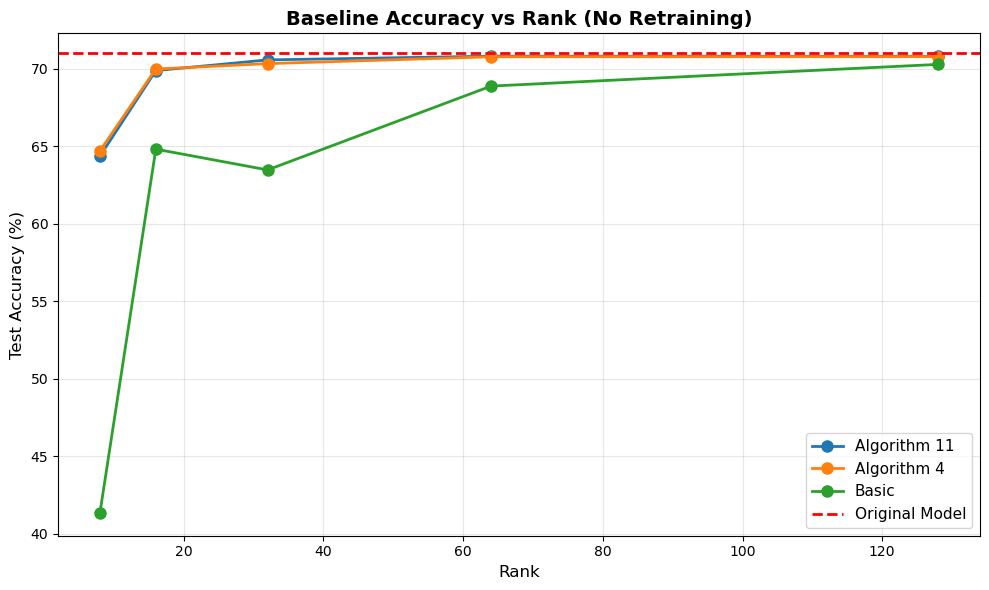

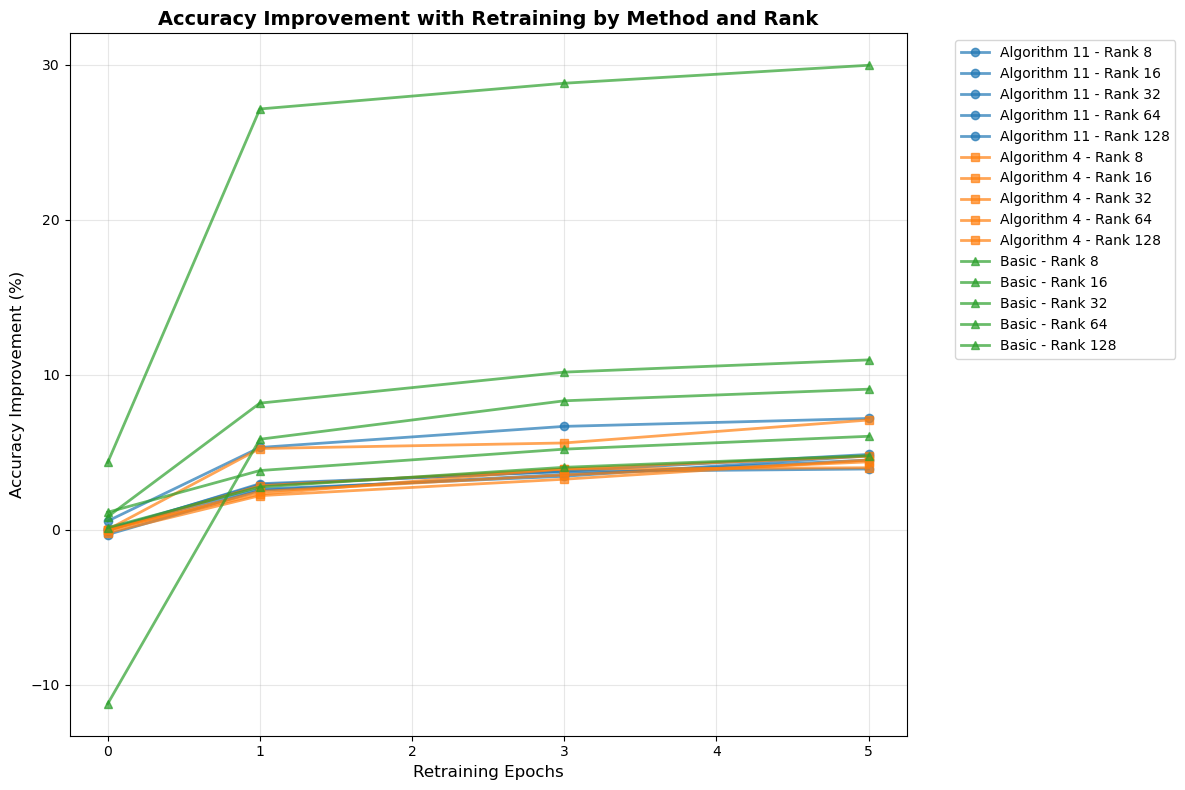

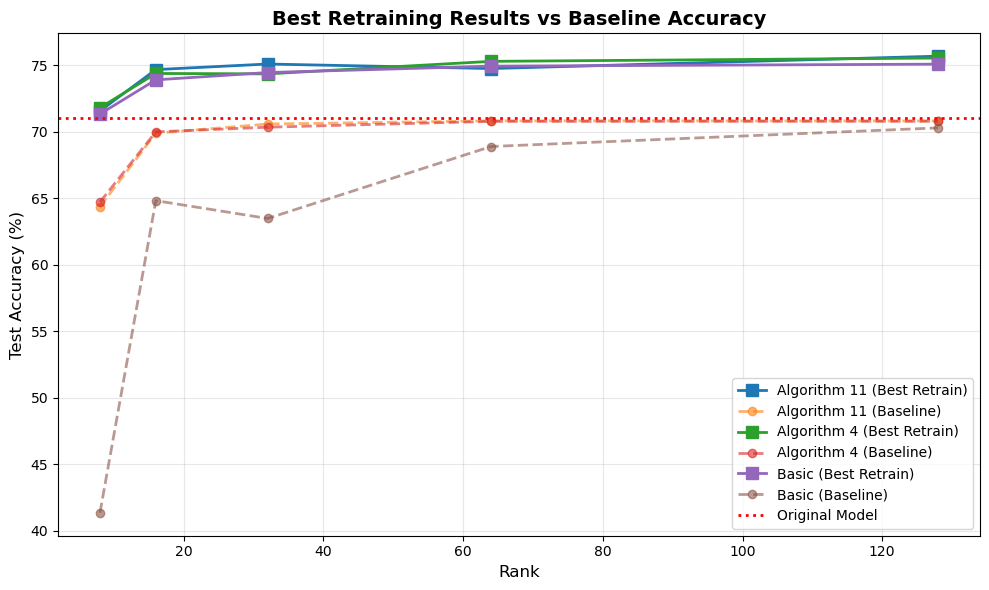

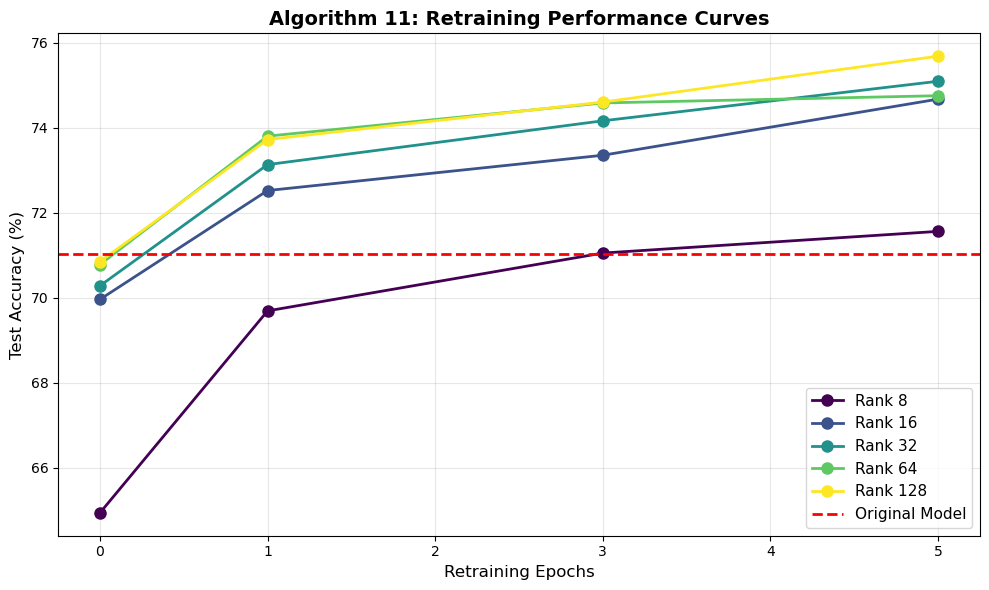

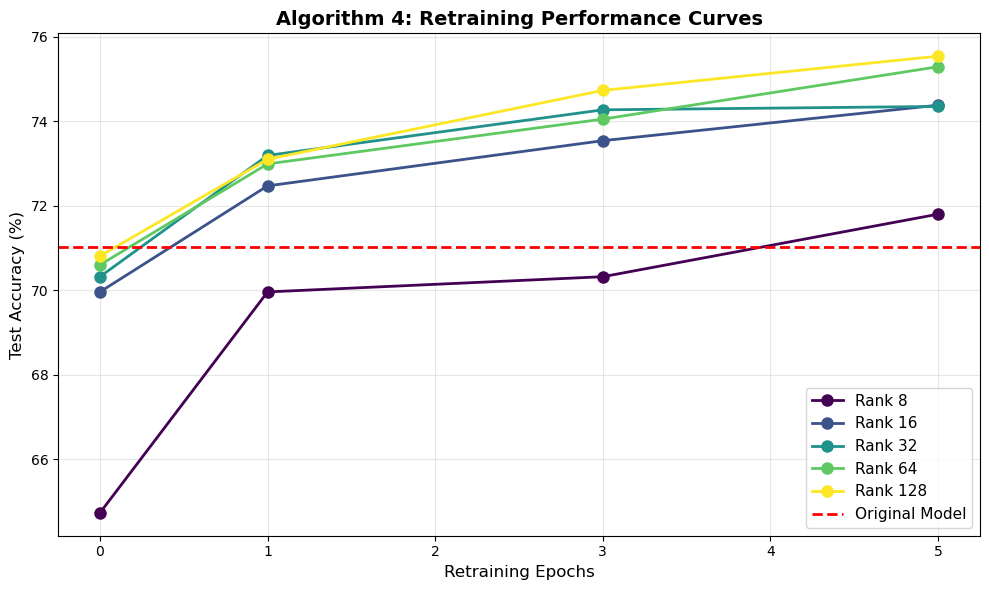

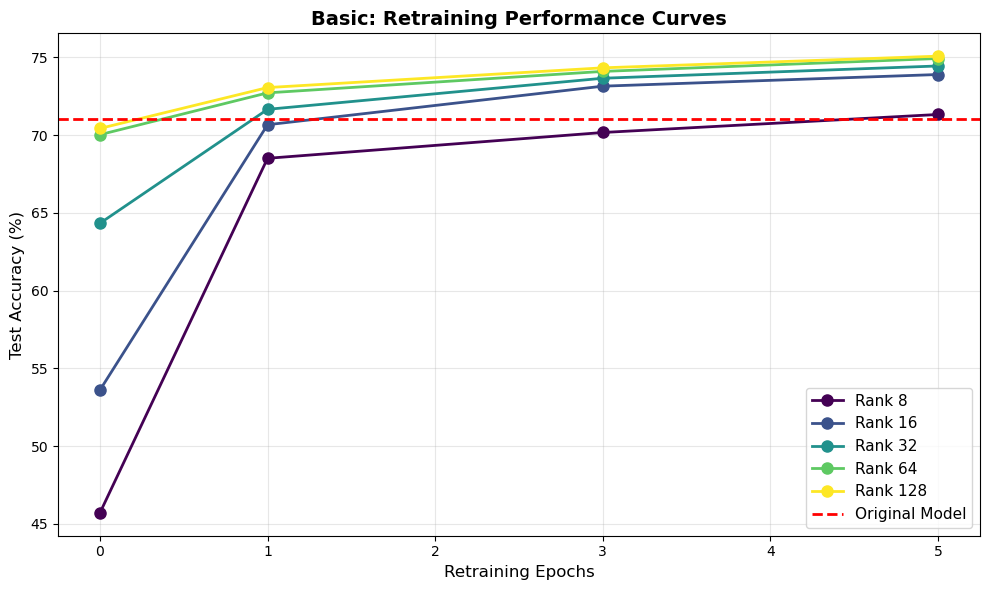

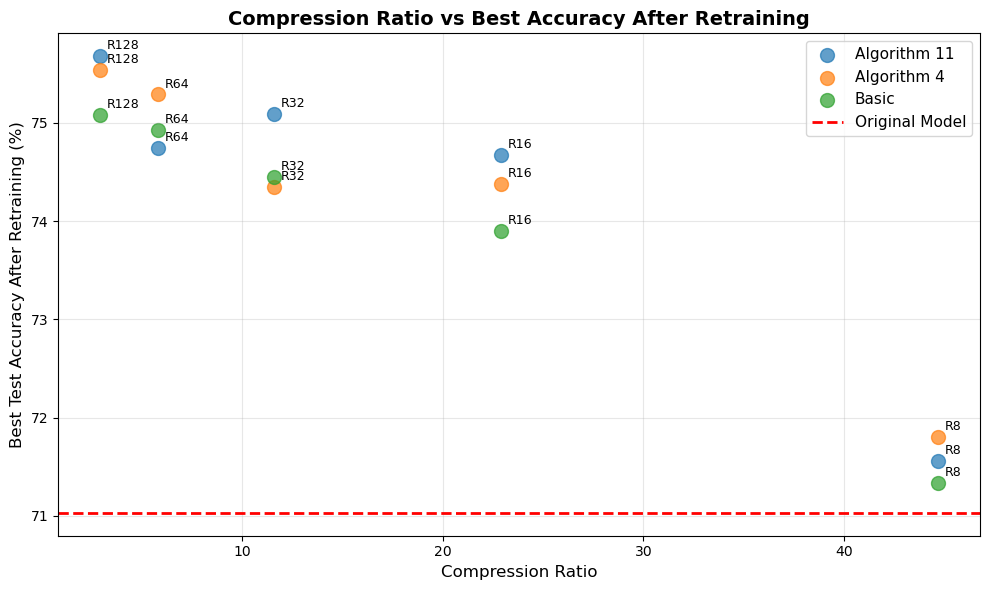

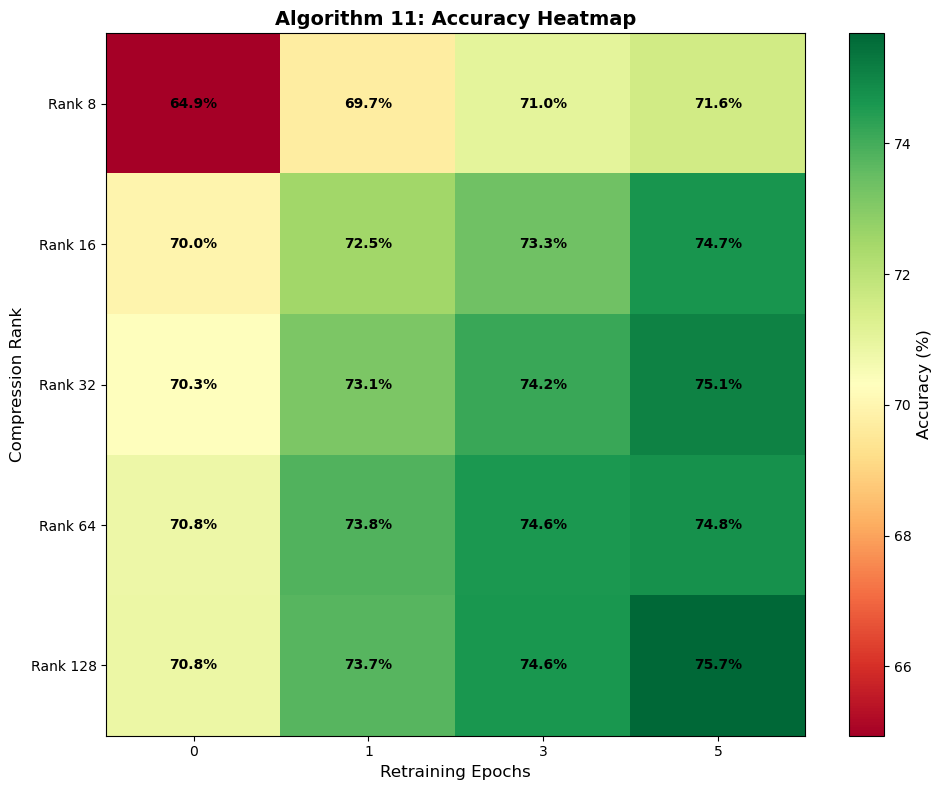

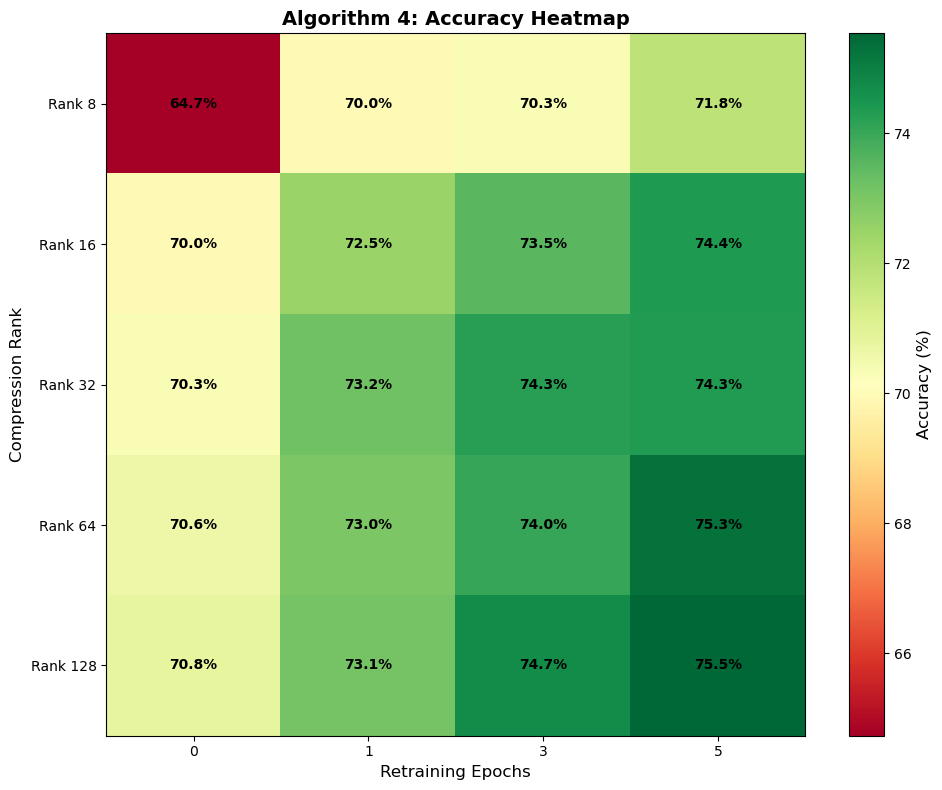

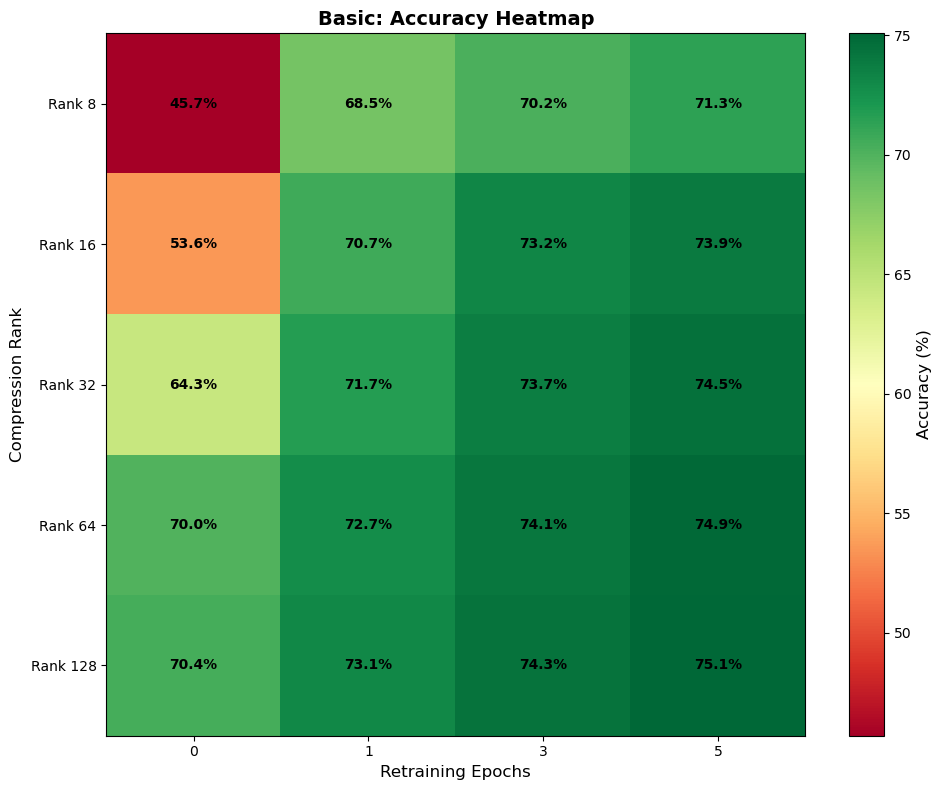

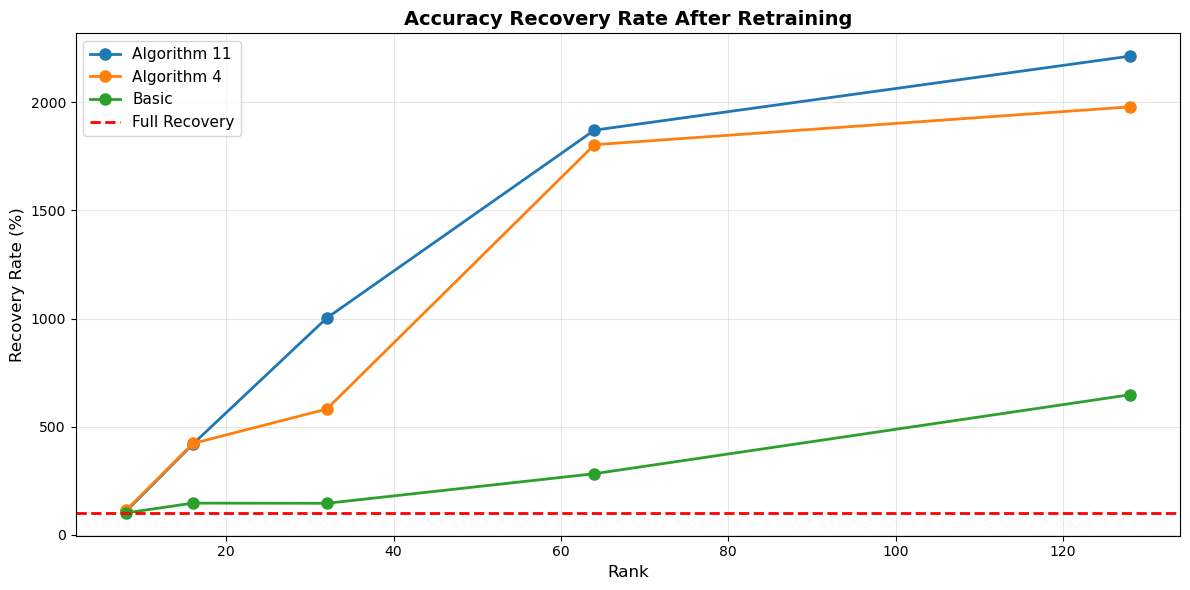

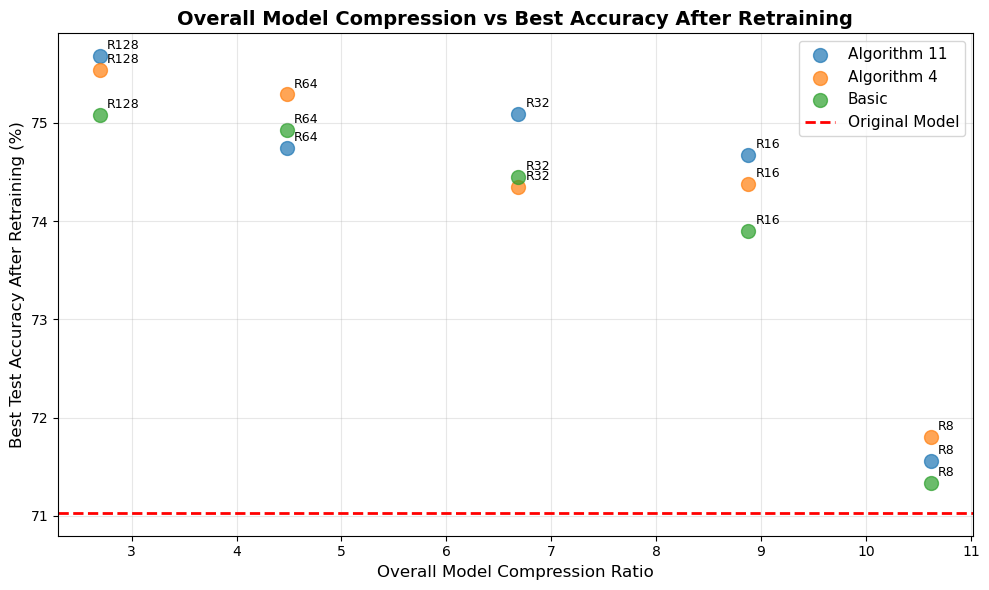


SUMMARY OF RESULTS WITH RETRAINING AND OVERALL COMPRESSION
Original Model Parameters: 1,276,234


Algorithm 11:
  Rank   8: Baseline=64.37%, Layer compression=44.7x, Overall compression=10.62x, Time=0.017s
           Model params: 1,276,234 -> 120,150
           After 0 retrain epochs: 64.94% (++0.6%)
           After 1 retrain epochs: 69.69% (++5.3%)
           After 3 retrain epochs: 71.05% (++6.7%)
           After 5 retrain epochs: 71.56% (++7.2%)

  Rank  16: Baseline=69.89%, Layer compression=22.9x, Overall compression=8.88x, Time=0.027s
           Model params: 1,276,234 -> 143,714
           After 0 retrain epochs: 69.96% (++0.1%)
           After 1 retrain epochs: 72.52% (++2.6%)
           After 3 retrain epochs: 73.35% (++3.5%)
           After 5 retrain epochs: 74.67% (++4.8%)

  Rank  32: Baseline=70.58%, Layer compression=11.6x, Overall compression=6.69x, Time=0.040s
           Model params: 1,276,234 -> 190,842
           After 0 retrain epochs: 70.28% (+-0.3%)
        

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:
# ============================================================================
# FINAL EXECUTION
# ============================================================================
print("="*60)
print("COMPLETE IMPLEMENTATION OF ALGORITHMS 4 & 11")
print("Halko, Martinsson, and Tropp (2010)")
print("="*60)
# Run comprehensive experiment
results = comprehensive_fc_compression_experiment()
# Analyze layer spectra
print("\n" + "="*60)
print("ANALYZING FC LAYER SPECTRA")
print("="*60)
# Load a trained model to analyze
trainloader, testloader = load_cifar10_data()
model = SimpleCNN()
train_model(model, trainloader, testloader, epochs=2)


Analyzing FC1 layer:


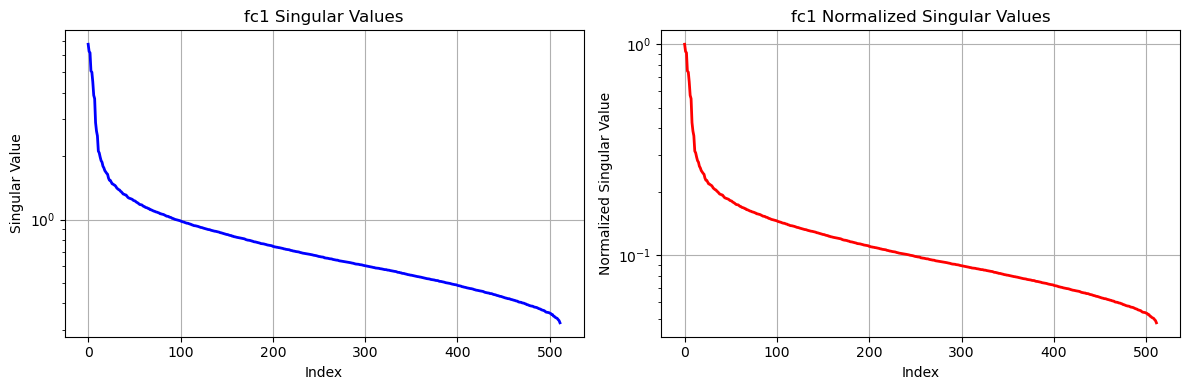

fc1 shape: (512, 2048)
Rank: 512
Condition number: 2.09e+01
Average log decay rate: -0.0060

Analyzing FC2 layer:


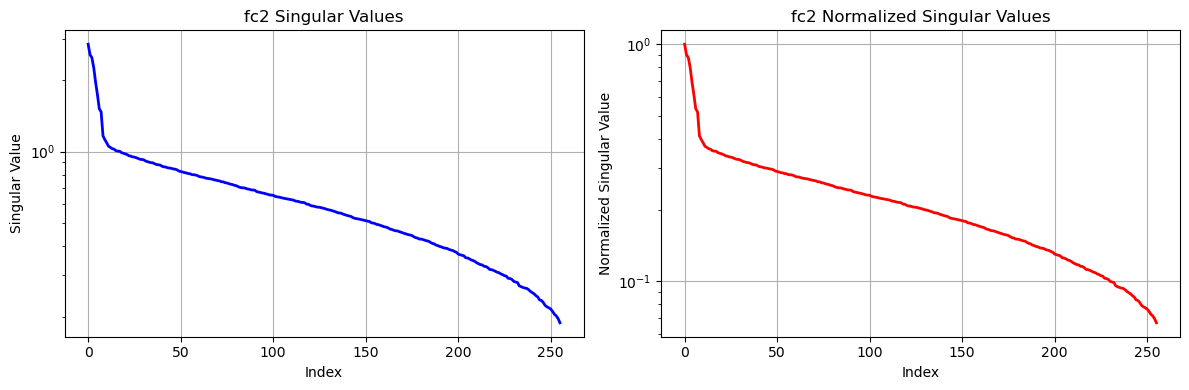

fc2 shape: (256, 512)
Rank: 256
Condition number: 1.50e+01
Average log decay rate: -0.0106

Experiment completed!


In [15]:
# Analyze FC layer spectra
print("\nAnalyzing FC1 layer:")
analyze_fc_layer_spectrum(model, 'fc1')
print("\nAnalyzing FC2 layer:")
analyze_fc_layer_spectrum(model, 'fc2')
print("\nExperiment completed!")